# Compare metrics - pyviskit vs viskit_offline

In [10]:
! mkdir results

In [1]:
from pyviskit import types, IVHD
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import random

from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split

markers = ["x", "o", "s", "*", "^", ".", "X"]
colors = ["red", "blue", "green", "brown", "orange", "cyan", "grey", "purple"]


def knngain(d_hd, d_ld, labels):
    # Number of data points
    N = d_hd.shape[0]
    N_1 = N - 1
    k_hd = np.zeros(shape=N_1, dtype=np.int64)
    k_ld = np.zeros(shape=N_1, dtype=np.int64)
    # For each data point
    for i in range(N):
        c_i = labels[i]
        di_hd = d_hd[i, :].argsort(kind="mergesort")
        di_ld = d_ld[i, :].argsort(kind="mergesort")
        # Making sure that i is first in di_hd and di_ld
        for arr in [di_hd, di_ld]:
            for idj, j in enumerate(arr):
                if j == i:
                    idi = idj
                    break
            if idi != 0:
                arr[idi] = arr[0]
            arr = arr[1:]
        for k in range(N_1):
            if c_i == labels[di_hd[k]]:
                k_hd[k] += 1
            if c_i == labels[di_ld[k]]:
                k_ld[k] += 1
    # Computing the KNN gain
    gn = (k_ld.cumsum() - k_hd.cumsum()).astype(np.float64) / (
        (1.0 + np.arange(N_1)) * N
    )
    # Returning the KNN gain and its AUC
    return gn, eval_auc(gn)


def eval_auc(arr):
    i_all_k = 1.0 / (np.arange(arr.size) + 1.0)
    return np.float64(arr.dot(i_all_k)) / (i_all_k.sum())


def eval_rnx(Q):
    N_1 = Q.shape[0]
    N = N_1 + 1
    # Computing Q_NX
    qnxk = np.empty(shape=N_1, dtype=np.float64)
    acc_q = 0.0
    for K in range(N_1):
        acc_q += Q[K, K] + np.sum(Q[K, :K]) + np.sum(Q[:K, K])
        qnxk[K] = acc_q / ((K + 1) * N)
    # Computing R_NX
    arr_K = np.arange(N_1)[1:].astype(np.float64)
    rnxk = (N_1 * qnxk[: N_1 - 1] - arr_K) / (N_1 - arr_K)
    # Returning
    return rnxk


def eval_dr_quality(d_hd, d_ld):
    # Computing the co-ranking matrix of the embedding, and the R_{NX}(K) curve.
    rnxk = eval_rnx(Q=coranking(d_hd=d_hd, d_ld=d_ld))
    # Computing the AUC, and returning.
    return rnxk, eval_auc(rnxk)


def coranking(d_hd, d_ld):
    # Computing the permutations to sort the rows of the distance matrices in HDS and LDS.
    perm_hd = d_hd.argsort(axis=-1, kind="mergesort")
    perm_ld = d_ld.argsort(axis=-1, kind="mergesort")

    N = d_hd.shape[0]
    i = np.arange(N, dtype=np.int64)
    # Computing the ranks in the LDS
    R = np.empty(shape=(N, N), dtype=np.int64)
    for j in range(N):
        R[perm_ld[j, i], j] = i
    # Computing the co-ranking matrix
    Q = np.zeros(shape=(N, N), dtype=np.int64)
    for j in range(N):
        Q[i, R[perm_hd[j, i], j]] += 1
    # Returning
    return Q[1:, 1:]


def viz_qa(
    Ly,
    ymin=None,
    ymax=None,
    Lmarkers=None,
    Lcols=None,
    Lleg=None,
    Lls=None,
    Lmedw=None,
    Lsdots=None,
    lw=2,
    markevery=0.1,
    tit="",
    folder_name="",
    xlabel="",
    ylabel="",
    alpha_plot=0.9,
    alpha_leg=0.8,
    stit=25,
    sax=20,
    sleg=15,
    zleg=1,
    loc_leg="best",
    ncol_leg=1,
    lMticks=10,
    lmticks=5,
    wMticks=2,
    wmticks=1,
    nyMticks=11,
    mymticks=4,
    grid=True,
    grid_ls="solid",
    grid_col="lightgrey",
    grid_alpha=0.7,
    xlog=True,
):
    # Number of curves
    nc = len(Ly)
    # Checking the parameters
    if ymin is None:
        ymin = np.min(np.asarray([arr.min() for arr in Ly]))
    if ymax is None:
        ymax = np.max(np.asarray([arr.max() for arr in Ly]))
    if Lmarkers is None:
        Lmarkers = ["x"] * nc
    if Lcols is None:
        Lcols = ["blue"] * nc
    if Lleg is None:
        Lleg = [None] * nc
        add_leg = False
    else:
        add_leg = True
    if Lls is None:
        Lls = ["solid"] * nc
    if Lmedw is None:
        Lmedw = [float(lw) / 2.0] * nc
    if Lsdots is None:
        Lsdots = [12] * nc

    # Setting the limits of the y-axis
    y_lim = [ymin, ymax]

    # Defining the ticks on the y-axis
    yMticks = np.linspace(
        start=ymin, stop=ymax, num=nyMticks, endpoint=True, retstep=False
    )
    ymticks = np.linspace(
        start=ymin,
        stop=ymax,
        num=1 + mymticks * (nyMticks - 1),
        endpoint=True,
        retstep=False,
    )
    yMticksLab = [int(round(v * 100.0)) / 100.0 for v in yMticks]

    # Initial values for xmin and xmax
    xmin, xmax = 1, -np.inf

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    if xlog:
        fplot = ax.semilogx
    else:
        fplot = ax.plot

    # Plotting the data
    for id, y in enumerate(Ly):
        x = np.arange(start=1, step=1, stop=y.size + 0.5, dtype=np.int64)
        xmax = max(xmax, x[-1])
        fplot(
            x,
            y,
            label=Lleg[id],
            alpha=alpha_plot,
            color=Lcols[id],
            linestyle=Lls[id],
            lw=lw,
            marker=Lmarkers[id],
            markeredgecolor=Lcols[id],
            markeredgewidth=Lmedw[id],
            markersize=Lsdots[id],
            dash_capstyle="round",
            solid_capstyle="round",
            dash_joinstyle="round",
            solid_joinstyle="round",
            markerfacecolor=Lcols[id],
            markevery=markevery,
        )

    # Setting the limits of the axes
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(y_lim)

    # Setting the major and minor ticks on the y-axis
    ax.set_yticks(yMticks, minor=False)
    ax.set_yticks(ymticks, minor=True)
    ax.set_yticklabels(yMticksLab, minor=False, fontsize=sax)

    # Defining the legend
    if add_leg:
        leg = ax.legend(
            loc=loc_leg,
            fontsize=sleg,
            markerfirst=True,
            fancybox=True,
            framealpha=alpha_leg,
            ncol=ncol_leg,
        )
        if zleg is not None:
            leg.set_zorder(zleg)

    # Setting the size of the ticks labels on the x axis
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(sax)

    # Setting ticks length and width
    ax.tick_params(axis="both", length=lMticks, width=wMticks, which="major")
    ax.tick_params(axis="both", length=lmticks, width=wmticks, which="minor")

    # Setting the positions of the labels
    ax.xaxis.set_tick_params(labelright=False, labelleft=True)
    ax.yaxis.set_tick_params(labelright=False, labelleft=True)

    # Adding the grids
    if grid:
        ax.xaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
        ax.yaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
    ax.set_axisbelow(True)

    ax.set_title(tit, fontsize=stit)
    ax.set_xlabel(xlabel, fontsize=sax)
    ax.set_ylabel(ylabel, fontsize=sax)
    # plt.tight_layout()

    # Showing the figure
    fig.savefig(
        "./results/{}.png".format(
            tit
        ),
        dpi=fig.dpi,
    )


class LocalMetric:
    def __init__(self):
        self.L_rnx = []
        self.L_kg = []
        self.Lleg_rnx = []
        self.Lleg_kg = []
        self.Lls = []
        self.number_of_methods = 0

    def calculate_knn_gain_and_dr_quality(
        self,
        X_lds: np.ndarray,
        X_hds: np.ndarray,
        labels: np.ndarray,
        method_name: str,
    ):

        (
            X_hds_train,
            X_hds_test,
            X_lds_train,
            X_lds_test,
            labels_train,
            labels_test,
        ) = train_test_split(X_hds, X_lds, labels, test_size=0.15)

        print("Calculating d_hd")
        d_hd = squareform(X=pdist(X=X_hds_test, metric="euclidean"), force="tomatrix")

        print(method_name)
        d_ld = squareform(X=pdist(X=X_lds_test, metric="euclidean"), force="tomatrix")
        rnxk, auc_rnx = eval_dr_quality(d_hd=d_hd, d_ld=d_ld)
        kg, auc_kg = knngain(d_hd=d_hd, d_ld=d_ld, labels=labels_test)

        self.L_rnx.append(rnxk)
        self.L_kg.append(kg)
        self.Lleg_rnx.append(
            "{} {}".format(int(round(auc_rnx * 1000)) / 1000.0, method_name)
        )
        self.Lleg_kg.append(
            "{} {}".format(int(round(auc_kg * 1000)) / 1000.0, method_name)
        )
        self.Lls.append("solid")
        self.number_of_methods = self.number_of_methods + 1

    def visualize(self):
        Lmarkers = random.sample(markers, self.number_of_methods)
        Lcols = random.sample(colors, self.number_of_methods)
        Lmedw = [1.0] * self.number_of_methods
        Lsdots = [12] * self.number_of_methods

        viz_qa(
            Ly=self.L_rnx,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_rnx,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="DR quality",
            xlabel="Neighborhood size $K$",
            ylabel="$R_{NX}(K)$",
        )

        viz_qa(
            Ly=self.L_kg,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_kg,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="KNN gain",
            xlabel="Neighborhood size $K$",
            ylabel="$G_{NN}(K)$",
        )

        print("Finished.")


In [3]:
input_data = "../../../../viskit_offline/mnist_data.csv"
labels_path = "../../../../viskit_offline/mnist_targets_2.csv"
graph = "../../../../viskit_offline/mnist_euclidean.bin"

In [4]:
hd_points = pd.read_csv(input_data).to_numpy()
labels = pd.read_csv(labels_path, header=None).to_numpy()

### Adadelta

#### Pyviskit

In [25]:
optimizer = types.OptimizerType.Adadelta
ivhd = IVHD.IVHD(optimizer, iterations=5000)
result = ivhd.fit_transform(input_data, labels_path, graph)

In [26]:
result.drop(result.tail(1).index,inplace=True)

Calculating d_hd
Adadelta pyviskit
Finished.


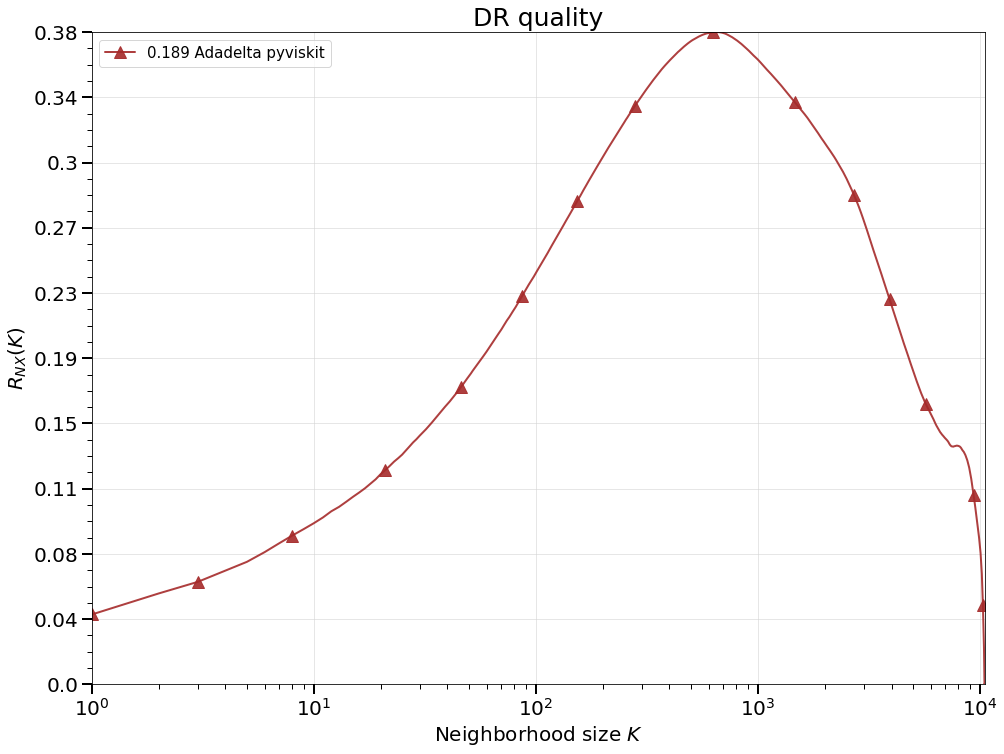

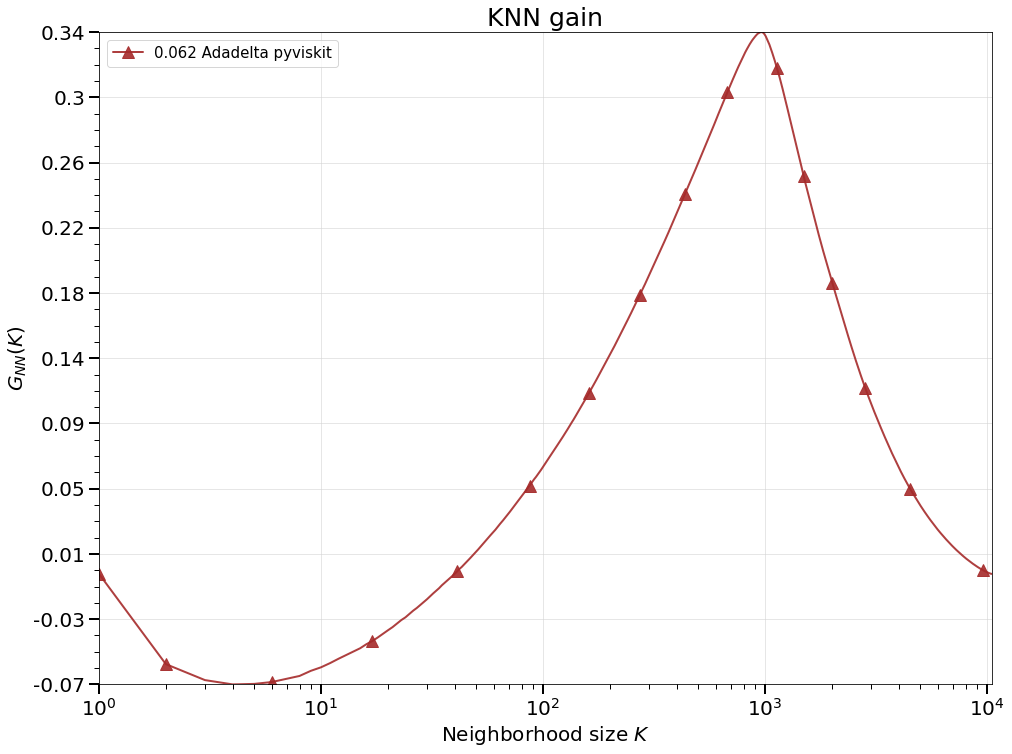

In [27]:
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[['x', 'y']].to_numpy(), hd_points, labels, "Adadelta pyviskit")
lm.visualize()

#### viskit_offline

Calculating d_hd
Adadelta viskit_offline
Finished.


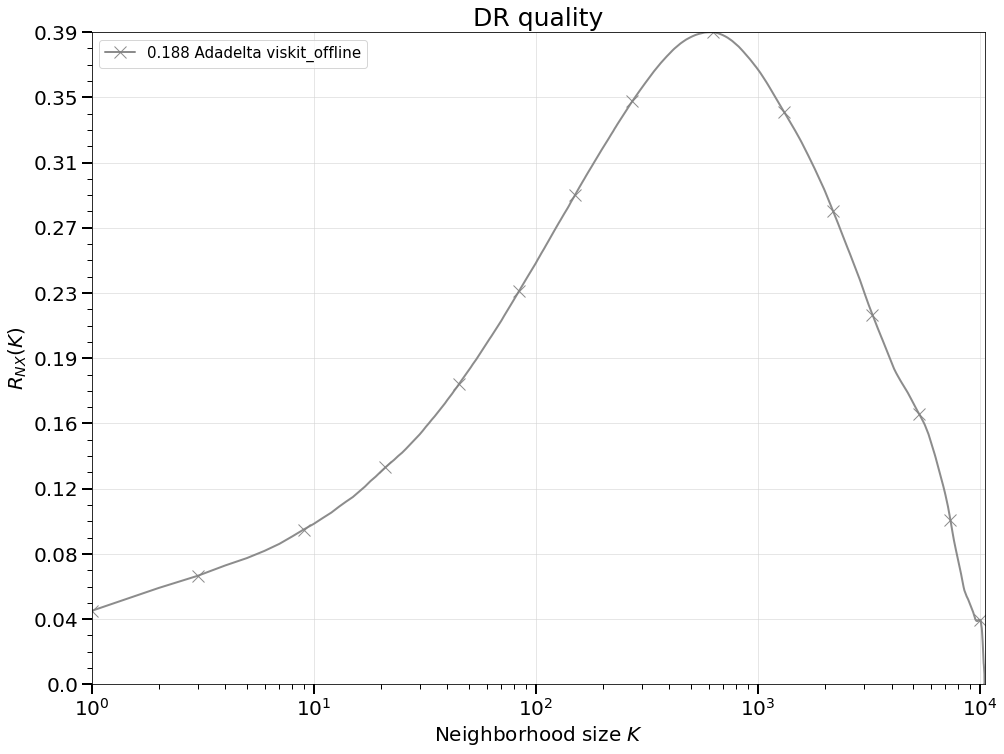

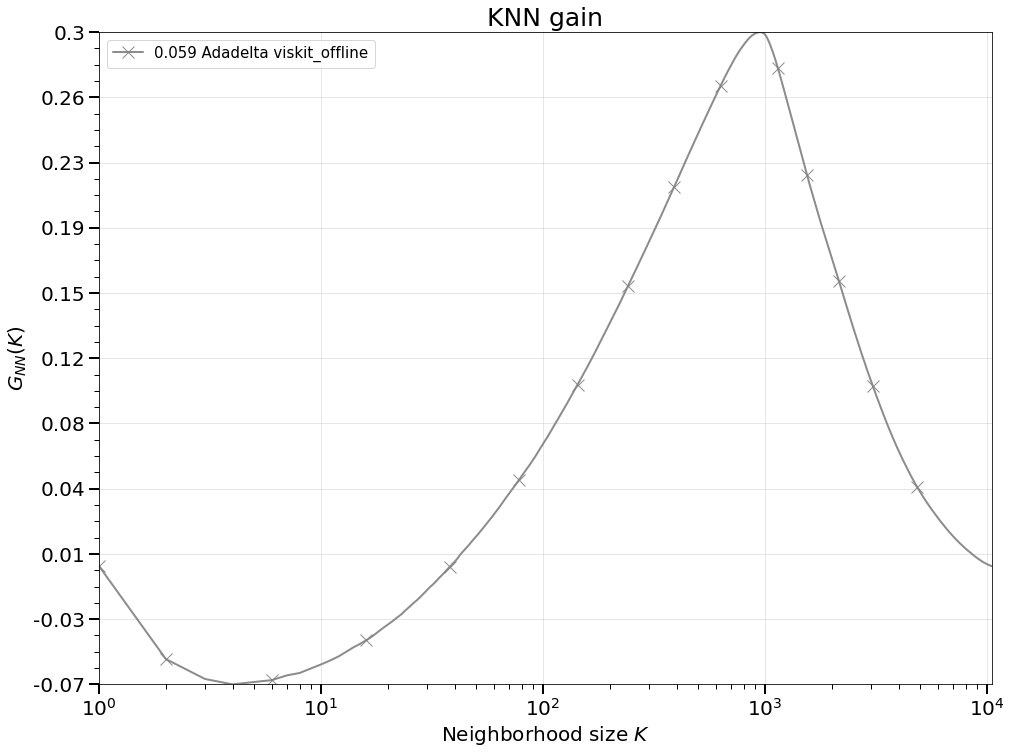

In [20]:
result = pd.read_csv("../../../../viskit_offline/visualizationadadelta.txt", header=None)
result.drop(result.tail(1).index,inplace=True)
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[[0, 1]].to_numpy(), hd_points, labels, "Adadelta viskit_offline")
lm.visualize()

### Adam

#### Pyviskit

In [28]:
optimizer = types.OptimizerType.Adam
ivhd = IVHD.IVHD(optimizer, iterations=5000)
result = ivhd.fit_transform(input_data, labels_path, graph)

In [29]:
result.drop(result.tail(1).index,inplace=True)

Calculating d_hd
Adam pyviskit
Finished.


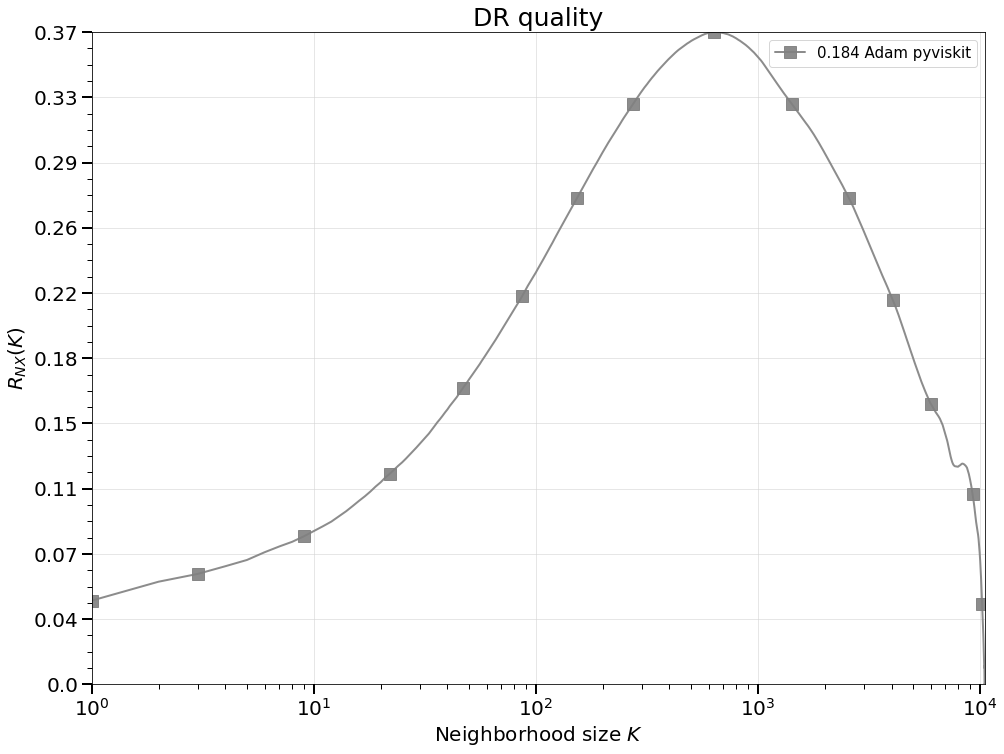

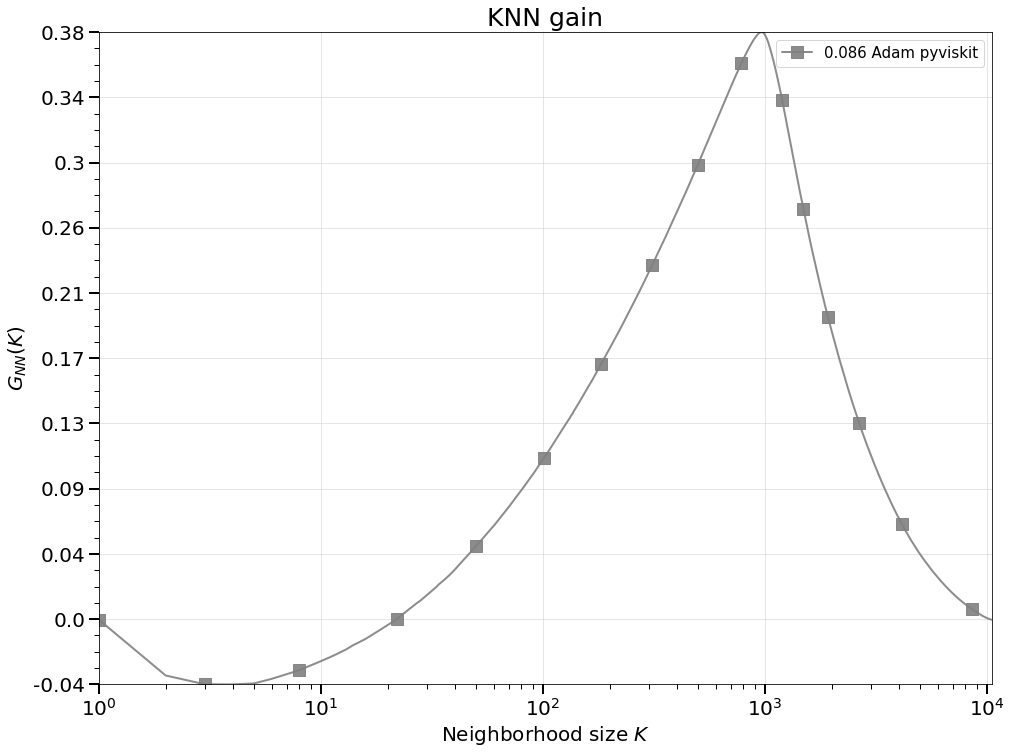

In [30]:
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[['x', 'y']].to_numpy(), hd_points, labels, "Adam pyviskit")
lm.visualize()

#### viskit_offline

Calculating d_hd
Adam viskit_offline
Finished.


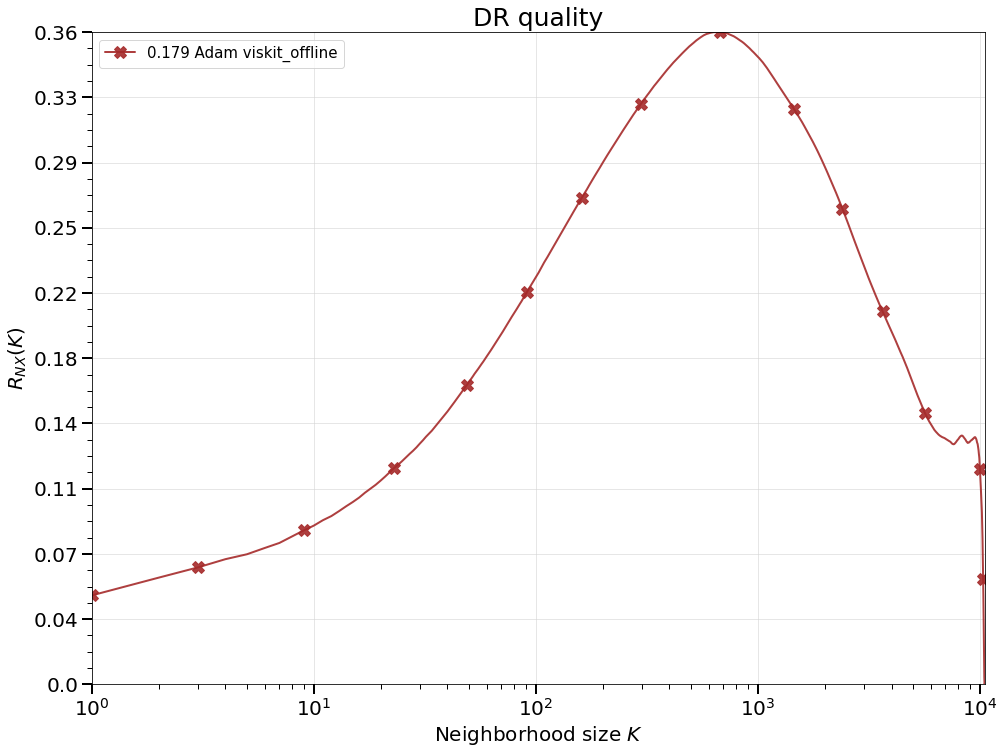

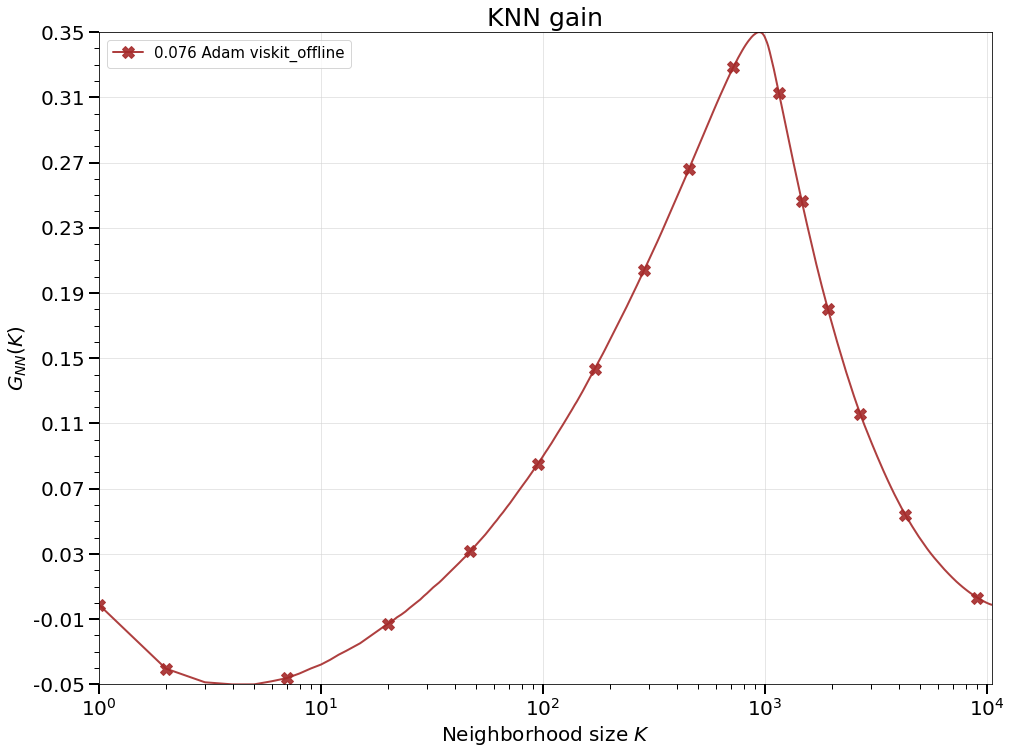

In [24]:
result = pd.read_csv("../../../../viskit_offline/visualizationadam.txt", header=None)
result.drop(result.tail(1).index,inplace=True)
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[[0, 1]].to_numpy(), hd_points, labels, "Adam viskit_offline")
lm.visualize()

### Force directed

#### pyviskit

In [32]:
optimizer = types.OptimizerType.ForceDirected
ivhd = IVHD.IVHD(optimizer, iterations=5000)
result = ivhd.fit_transform(input_data, labels_path, graph)

In [33]:
result.drop(result.tail(1).index,inplace=True)

Calculating d_hd
Force Directed pyviskit
Finished.


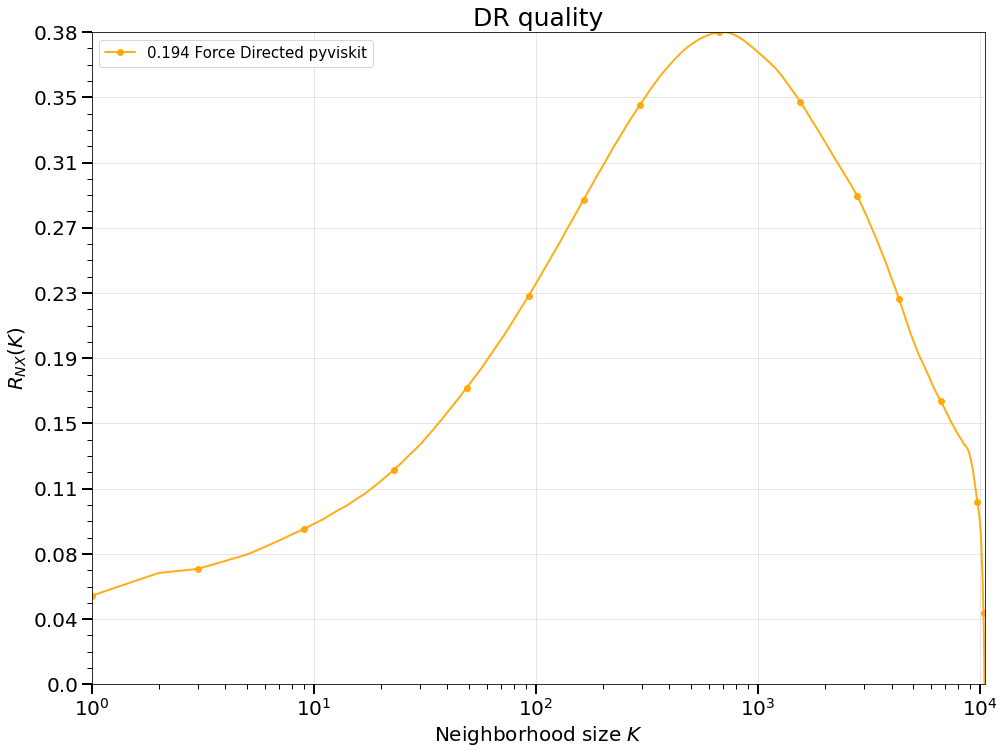

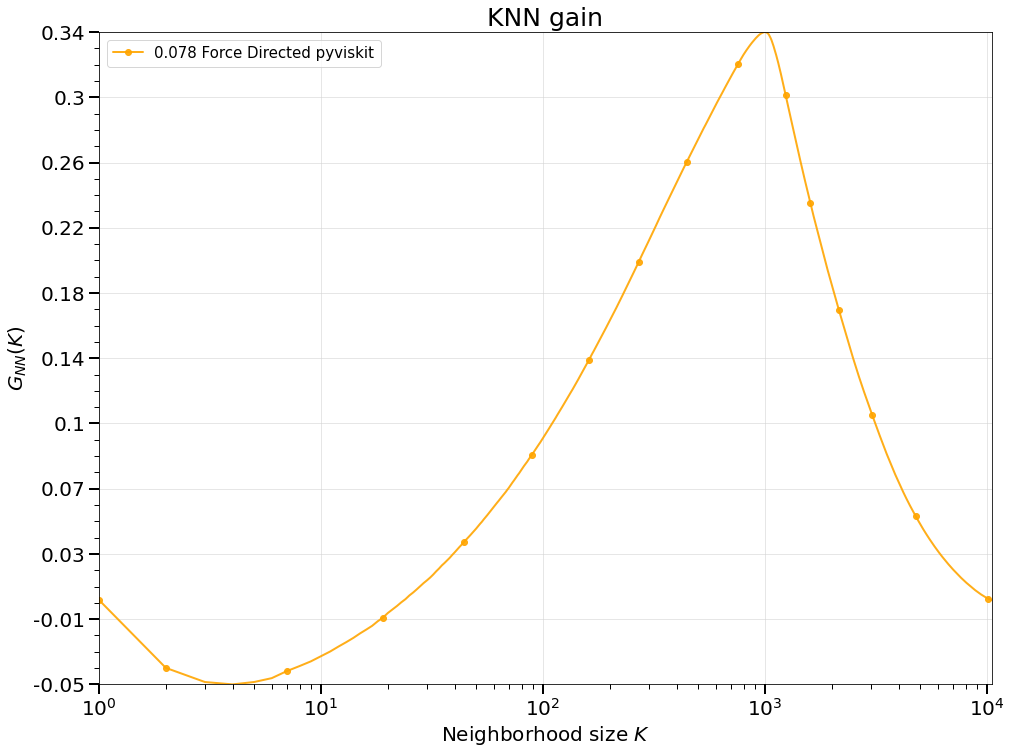

In [34]:
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[['x', 'y']].to_numpy(), hd_points, labels, "Force Directed pyviskit")
lm.visualize()

#### viskit_offline

Calculating d_hd
Force Directed viskit_offline
Finished.


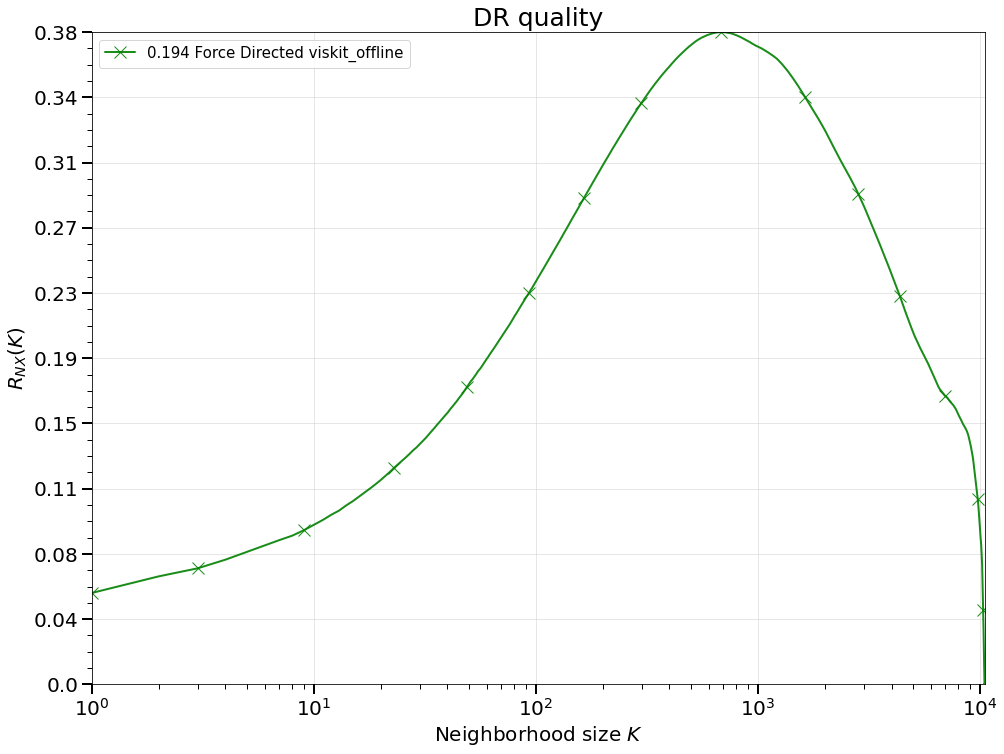

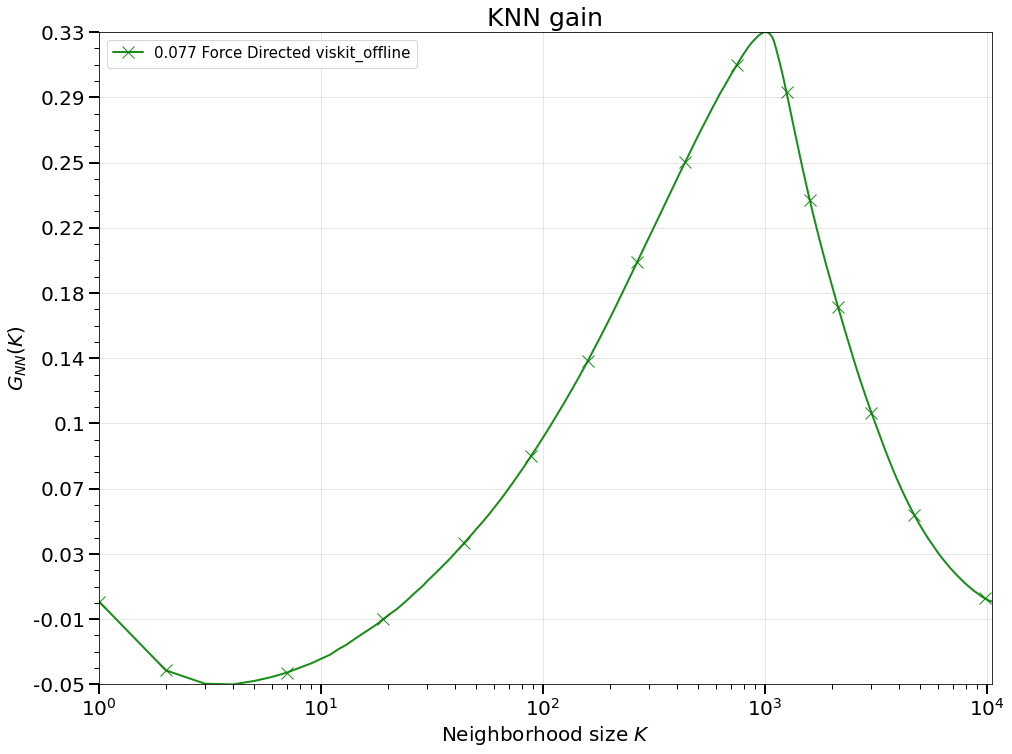

In [35]:
result = pd.read_csv("../../../../viskit_offline/visualizationforce-directed.txt", header=None)
result.drop(result.tail(1).index,inplace=True)
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[[0, 1]].to_numpy(), hd_points, labels, "Force Directed viskit_offline")
lm.visualize()

### Momentum

#### pyviskit

In [36]:
optimizer = types.OptimizerType.Momentum
ivhd = IVHD.IVHD(optimizer, iterations=5000)
result = ivhd.fit_transform(input_data, labels_path, graph)

In [37]:
result.drop(result.tail(1).index,inplace=True)

Calculating d_hd
Momentum pyviskit
Finished.


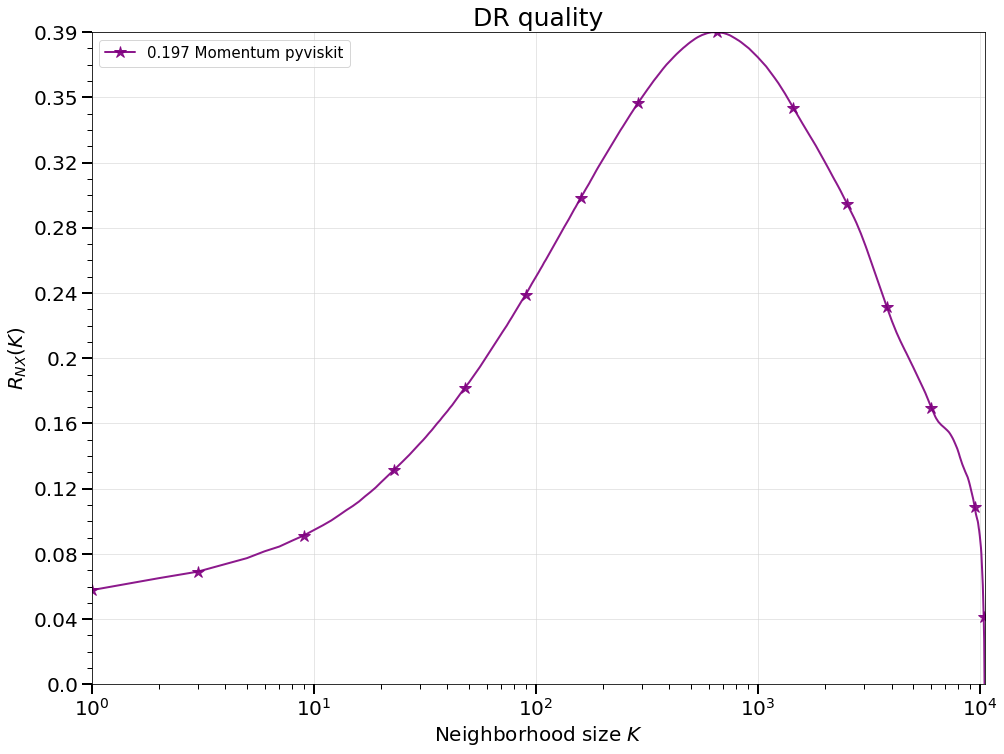

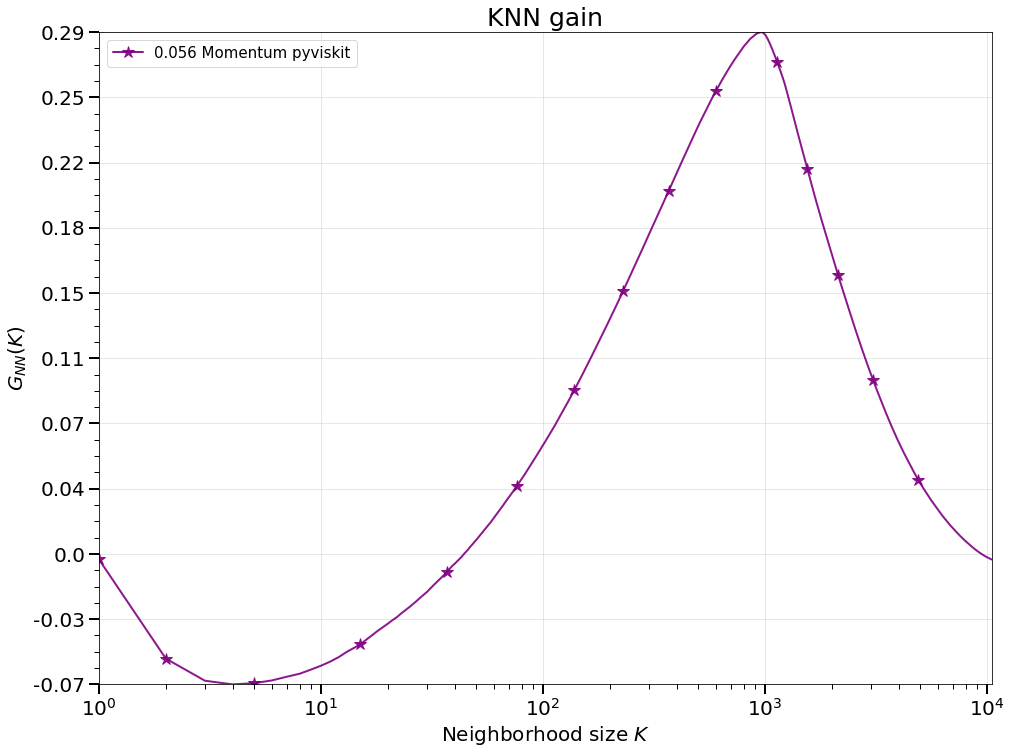

In [38]:
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[['x', 'y']].to_numpy(), hd_points, labels, "Momentum pyviskit")
lm.visualize()

#### viskit_offline

Calculating d_hd
Momentum viskit_offline
Finished.


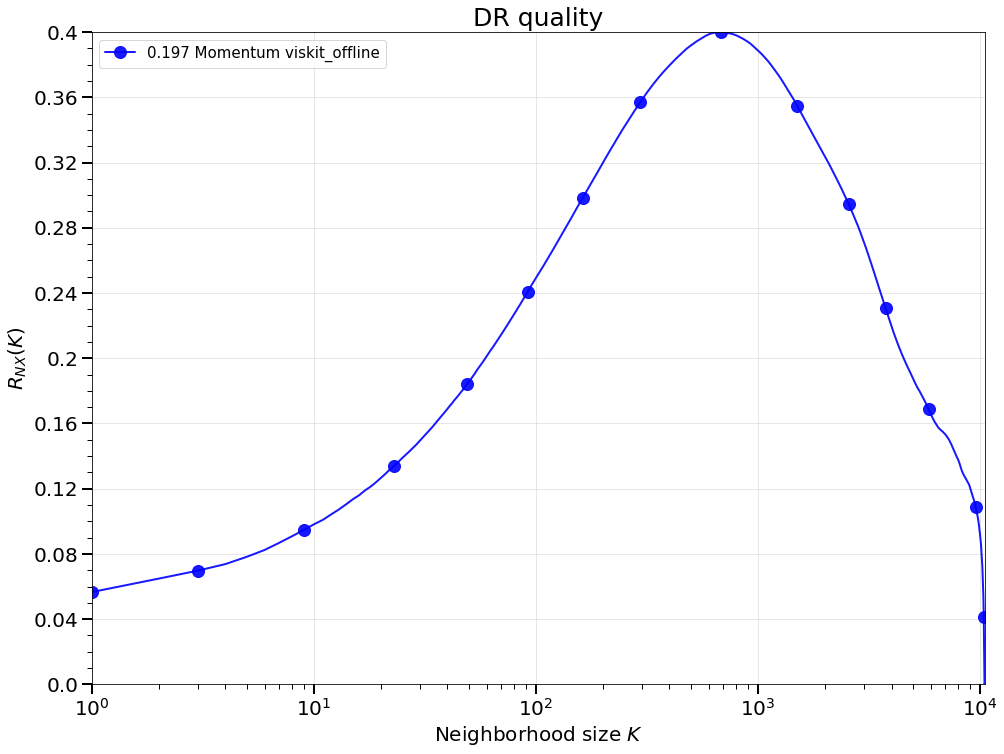

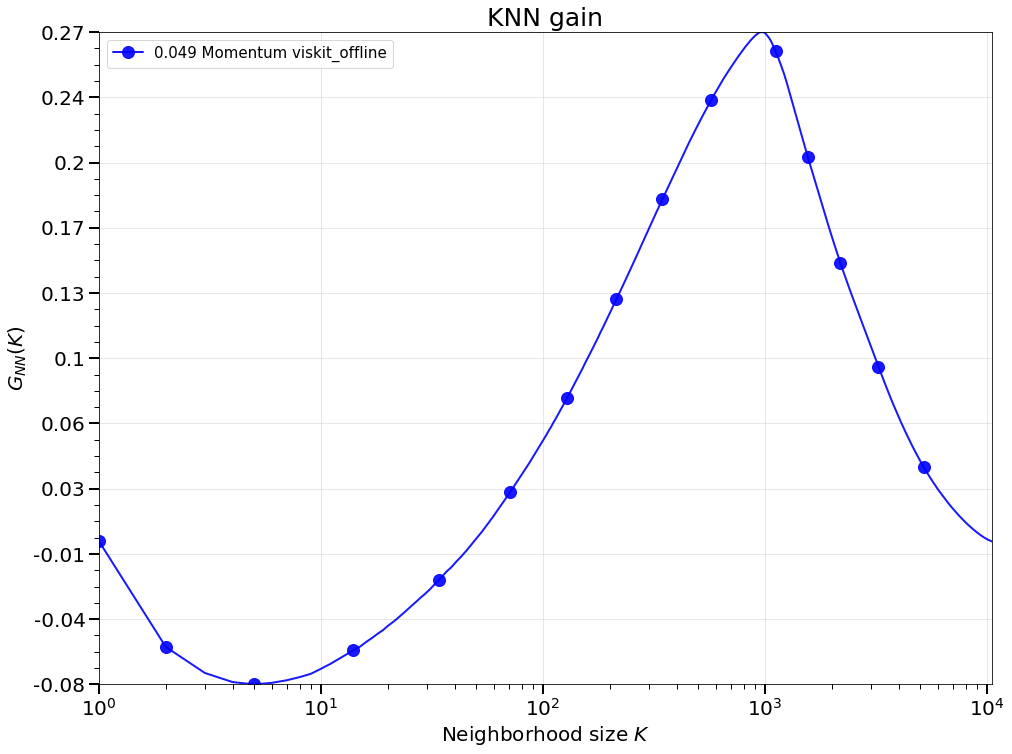

In [39]:
result = pd.read_csv("../../../../viskit_offline/visualizationmomentum.txt", header=None)
result.drop(result.tail(1).index,inplace=True)
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[[0, 1]].to_numpy(), hd_points, labels, "Momentum viskit_offline")
lm.visualize()

### Nesterov

#### pyviskit

In [40]:
optimizer = types.OptimizerType.Nesterov
ivhd = IVHD.IVHD(optimizer, iterations=5000)
result = ivhd.fit_transform(input_data, labels_path, graph)

In [41]:
result.drop(result.tail(1).index,inplace=True)

Calculating d_hd
Nesterov pyviskit
Finished.


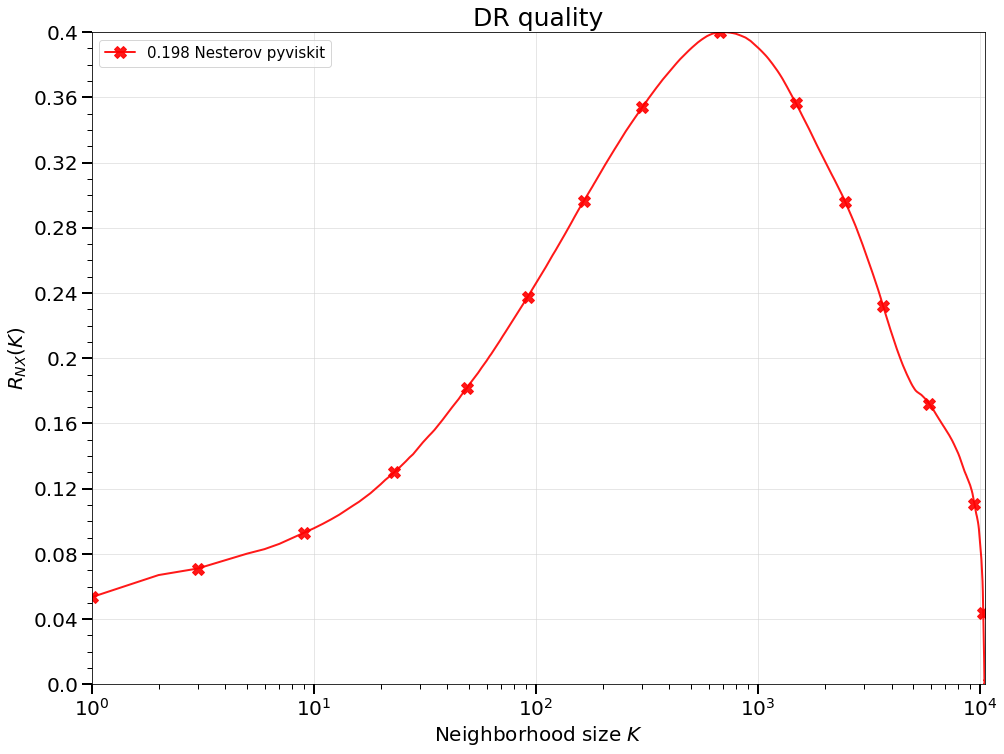

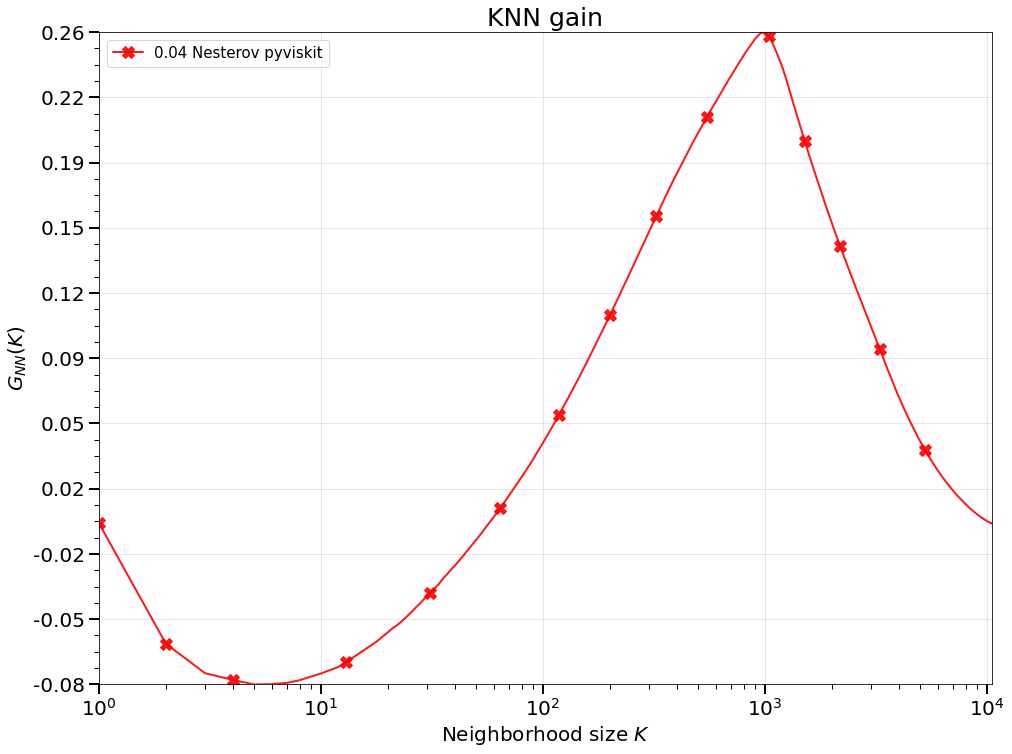

In [42]:
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[['x', 'y']].to_numpy(), hd_points, labels, "Nesterov pyviskit")
lm.visualize()

#### viskit_offline

Calculating d_hd
Nesterov viskit_offline
Finished.


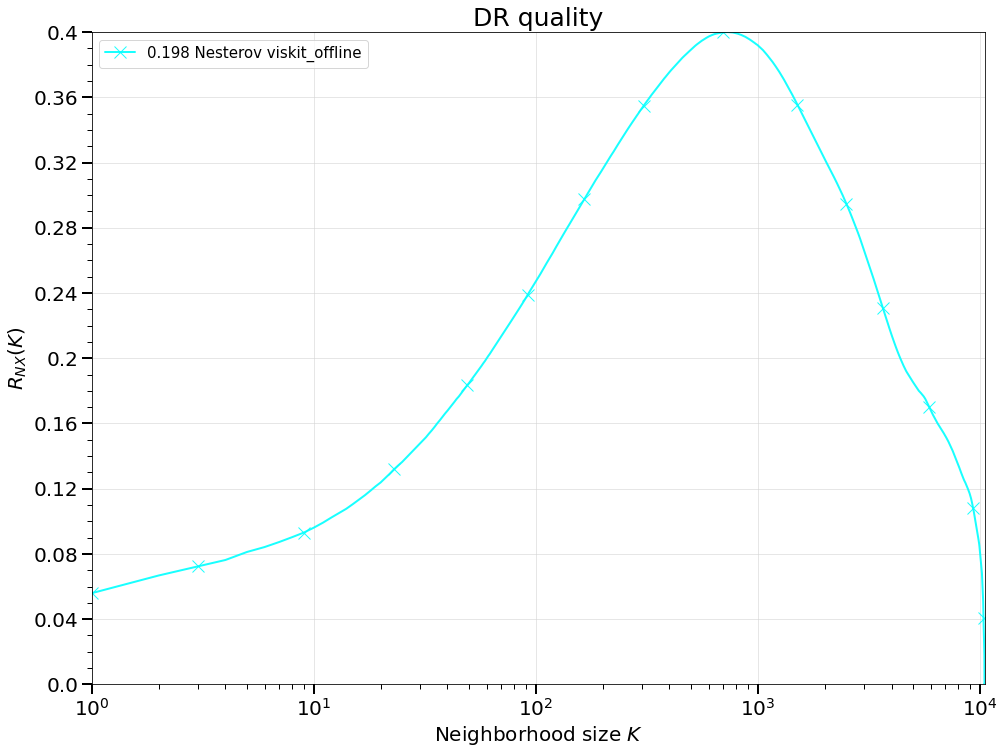

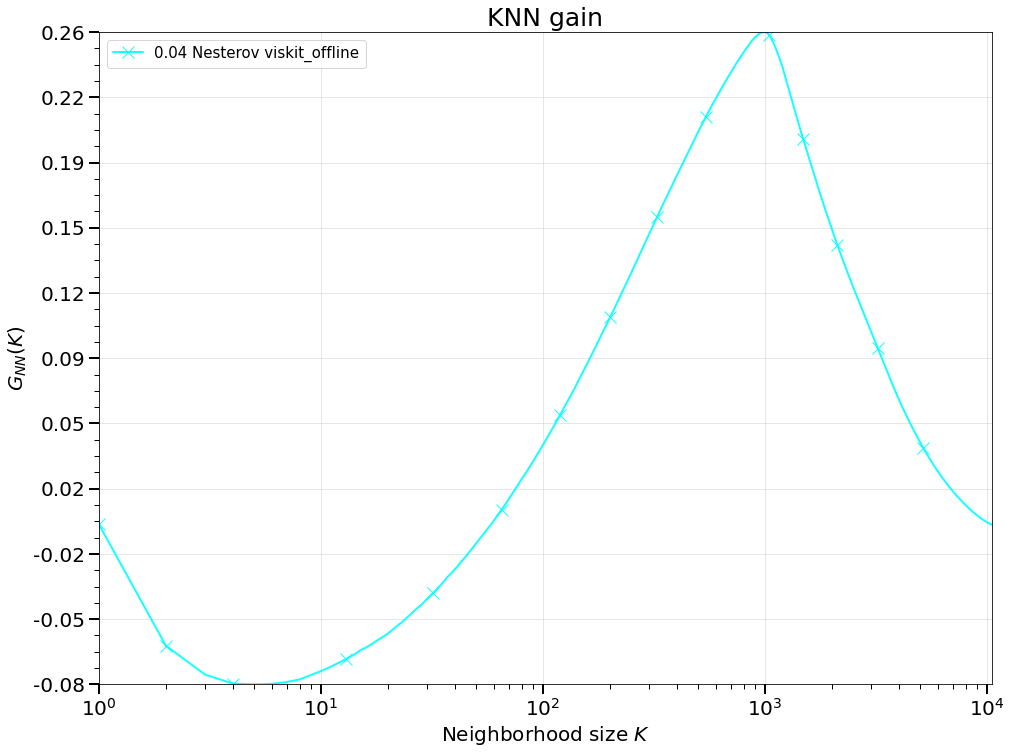

In [43]:
result = pd.read_csv("../../../../viskit_offline/visualizationnesterov.txt", header=None)
result.drop(result.tail(1).index,inplace=True)
lm = LocalMetric()
lm.calculate_knn_gain_and_dr_quality(result[[0, 1]].to_numpy(), hd_points, labels, "Nesterov viskit_offline")
lm.visualize()